<a href="https://colab.research.google.com/github/nankivel/capstone/blob/main/ResNet7_upd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00


In [26]:
import os
import datetime
import chess
import chess.engine
import random
import numpy as np
import pydot
from tqdm import tqdm
import io
import json
import graphviz
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, SVG

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!apt-get install -y stockfish

In [14]:
# help functions

def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish") as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
  return score

def board_encoder(board):
  encoded_board = np.zeros([8,8,15]).astype(np.int8)
  fen = board.fen()
  fen_field = fen.split(' ')
  PiecePlacement = fen_field[0].split('/')
  piece_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5,
                "r":6, "n":7, "b":8, "q":9, "k":10, "p":11
                }
  for rank in range(8):
    pieces = ''
    for c in PiecePlacement[rank]:
      if c.isnumeric():
        pieces += '-'*int(c)
      else:
        pieces += c
    for file in range(8):
      if pieces[file] != '-':
        encoded_board[rank, file, piece_dict[pieces[file]]] = 1
  # plane 12 encodes all the legal moves of white
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
    encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 12] = 1
  # plane 13 encodes all the legal moves of black
  board.turn = chess.BLACK
  for move in board.legal_moves:
    encoded_board[7-np.unravel_index(move.to_square, (8,8))[0], np.unravel_index(move.to_square, (8,8))[1], 13] = 1
  board.turn = aux
  # plane 14 encodes the current player to move: white is 1, black is 0
  if fen_field[1] == 'w':
    encoded_board[:,:,14] = 1
  else:
    encoded_board[:,:,14] = 0
  return encoded_board

In [ ]:
# load training data

# inputdata1 = np.load("/content/drive/MyDrive/dataset_lichess1.Mar18.npz")
# inputdata2 = np.load("/content/drive/MyDrive/dataset_lichess2.Mar18.npz")
# inputdata3 = np.load("/content/drive/MyDrive/dataset_lichess3.Mar18.npz")

# X = np.concatenate([inputdata1['X'], inputdata2['X'], inputdata2['X']])
# y = np.concatenate([inputdata1['y'], inputdata2['y'], inputdata2['y']])

#np.savez("/content/drive/MyDrive/dataset_lichess123.Mar18.npz", X=X, y=y)

inputdata = np.load("/content/drive/MyDrive/dataset_lichess123.Mar18.npz")

X = inputdata['X']
y = inputdata['y']
X.shape

(298594, 8, 8, 15)

In [15]:
# model components

class ConvBlock(nn.Module):
    def __init__(self, channel_in=15, channel_out=256, kernel_size=3, stride=1):
        super(ConvBlock, self).__init__()
        self.channel_in = channel_in
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size,
                               stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(channel_out)

    def forward(self, s):
        if s.dtype != torch.float32:
            s = s.float()
        s = s.view(-1, self.channel_in, 8, 8)  # batch_size x channels x board_x x board_y
        s = self.conv1(s)
        s = self.bn1(s)
        s = F.relu(s)
        return s

class ResBlock(nn.Module):
    def __init__(self, channel_in=256, channel_out=256, kernel_size=3, stride=1,
                 downsample=None):
        super(ResBlock, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=kernel_size,
                               stride=stride,
                     padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_out)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=kernel_size,
                               stride=stride,
                     padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(channel_out)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = F.relu(out)
        return out

class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 1, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(8*8, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self,s):
        v = self.conv(s)
        v = self.bn(v)
        v = F.relu(v)
        v = v.view(-1, 8*8)  # batch_size x channels x board_x x board_y
        v = self.fc1(v)
        v = F.relu(v)
        v = self.fc2(v)
        v = torch.tanh(v)

        return v

In [16]:
# 7 layers of residual blocks

class ResNet7(nn.Module):
    def __init__(self):
        super(ResNet7, self).__init__()
        self.conv = ConvBlock()
        self.resblocks = nn.ModuleList([ResBlock() for _ in range(7)])
        self.outblock = OutBlock()

    def forward(self,s):
        s = self.conv(s)
        for resblock in self.resblocks:
            s = resblock(s)
        s = self.outblock(s)
        return s

In [ ]:
class training_data():
    def __init__(self, dataset): # dataset = np.array of (s, v)
        # self.X = dataset[:,0]
        # self.y = dataset[:,1]
        self.X = dataset['X']
        self.y = np.array(dataset['y'] / abs(dataset['y']).max(),
                          dtype=np.float32) # normalized to [-1,1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        return self.X[idx].transpose(2,0,1), self.y[idx]

def train(net, dataset, batch_size=100, epoch_start=0, epoch_stop=20, checkpoint_interval=10):
    net.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[100,200,300,400],
                                               gamma=0.2)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)
    train_set = training_data(dataset)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=False)
    losses_per_epoch = []
    for epoch in range(epoch_start, epoch_stop):
        total_loss = 0.0
        losses_per_batch = []
        for i,data in enumerate(train_loader):
            state, value = data
            if cuda:
                state, value = state.cuda().float(), value.cuda().float()
            value = value.float()  # Convert to torch.float32
            optimizer.zero_grad()
            value_pred = net(state) # value_pred = torch.Size([batch, 1])
            loss = criterion(value_pred[:,0], value)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches of size = batch_size
                print('Process ID: %d [Epoch: %d, %5d/ %d points] total loss per batch: %.3f' %
                      (os.getpid(), epoch + 1, (i + 1)*batch_size, len(train_set), total_loss/10))
                print("Value:",value[0].item(),value_pred[0,0].item())
                losses_per_batch.append(total_loss/10)
                total_loss = 0.0
        losses_per_epoch.append(sum(losses_per_batch)/len(losses_per_batch))
        scheduler.step()
        # if len(losses_per_epoch) > 100:
        #     if abs(sum(losses_per_epoch[-4:-1])/3-sum(losses_per_epoch[-16:-13])/3) <= 0.01:
        #         break
        if epoch % checkpoint_interval == 0:
          torch.save({'state_dict': net.state_dict()},
                     "/content/drive/MyDrive/ResNet7_training_checkpoint_epoch{}.ckpt".format(epoch))

    np.savez("/content/drive/MyDrive/losses_per_epoch_ResNet7_50_100epoch.npz", X=losses_per_epoch)
    fig = plt.figure()
    ax = fig.add_subplot(222)
    ax.scatter([e for e in range(epoch_start,epoch_stop+1,1)], losses_per_epoch)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss per batch")
    ax.set_title("Loss vs Epoch")
    print('Finished Training')
    plt.savefig("/content/drive/MyDrive/Loss_vs_Epoch_%s.png" % datetime.datetime.today().strftime("%Y-%m-%d-%H-%M"))

In [ ]:
# train net
net = ResNet7()
cuda = torch.cuda.is_available()
if cuda:
  net.cuda()
# current_net_filename = r"C:\Users\Richard.Huang\OneDrive - TGS\Desktop\Jupyter\AlphaZero\model_data\ResNet7_training1.pth.tar"
# checkpoint = torch.load(current_net_filename)
# net.load_state_dict(checkpoint['state_dict'])
train(net,inputdata, epoch_stop=50)
# save results
torch.save({'state_dict': net.state_dict()}, "/content/drive/MyDrive/ResNet7_training1.pth.tar")

In [ ]:
# train net
net = ResNet7()
cuda = torch.cuda.is_available()
if cuda:
  net.cuda()
current_net_filename = "/content/drive/MyDrive/ResNet7_training1.pth.tar"
checkpoint = torch.load(current_net_filename)
net.load_state_dict(checkpoint['state_dict'])
train(net,inputdata, epoch_start=50, epoch_stop=100)
# save results
torch.save({'state_dict': net.state_dict()}, "/content/drive/MyDrive/ResNet7_trained1.pth.tar")

In [ ]:
losses_per_epoch_0_50 = np.load("/content/drive/MyDrive/losses_per_epoch_ResNet7_50epoch.npz")
losses_per_epoch_51_100 = np.load("/content/drive/MyDrive/losses_per_epoch_ResNet7_50_100epoch.npz")
losses_per_epoch = np.concatenate([losses_per_epoch_0_50['X'],
                                  losses_per_epoch_51_100['X']
                                   ]
                                  )

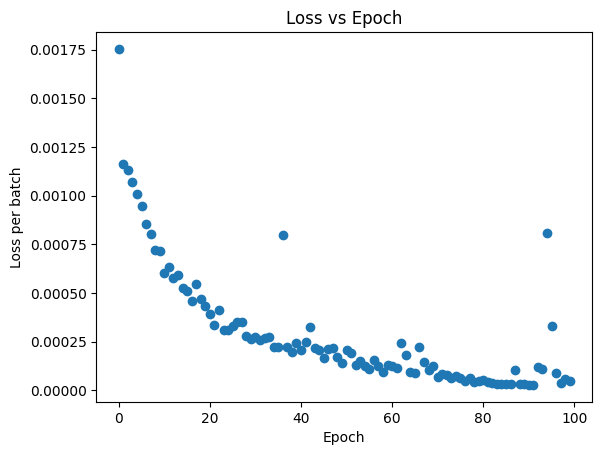

In [ ]:
# plot loss per epoch
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([e for e in range(100)], losses_per_epoch)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss per batch")
ax.set_title("Loss vs Epoch")
plt.show()

Playing...

In [21]:
model = ResNet7()
cuda = torch.cuda.is_available()
if cuda:
  model.cuda()
  checkpoint = torch.load("/content/drive/MyDrive/ResNet7_training_checkpoint_epoch80.ckpt")
  model.load_state_dict(checkpoint['state_dict'])
else:
  checkpoint = torch.load("/content/drive/MyDrive/ResNet7_training_checkpoint_epoch80.ckpt", map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])
model.eval()

def minimax_eval(board):
  board_rep = board_encoder(board)
  board_tensor = torch.tensor(board_rep.transpose(2,0,1), dtype=torch.float32)
  with torch.no_grad():
    output = model(board_tensor.unsqueeze(0))
  return output.item()

def minimax(board, depth, alpha, beta, maximizing=False):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  if maximizing: # maximizing the value
    max_val = -np.inf
    for move in board.legal_moves:
      board.push(move)
      val = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_val = max(max_val, val)
      alpha = max(alpha, val)
      if beta <= alpha:
        break
    return max_val
  else:
    min_val = np.inf
    for move in board.legal_moves:
      board.push(move)
      val = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_val = min(min_val, val)
      beta = min(beta, val)
      if beta <= alpha:
        break
    return min_val

def get_ai_move(board, depth):
  max_move = None
  max_val = -np.inf

  for move in board.legal_moves:
    board.push(move)
    val = minimax(board, depth - 1, -np.inf, np.inf, False)
    board.pop()
    if val > max_val:
      max_val = val
      max_move = move

  return max_move

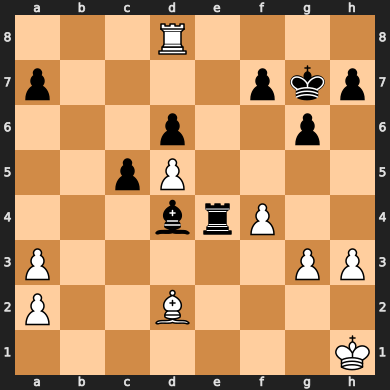

In [23]:
board = chess.Board(fen='3R4/p4pkp/3p2p1/2pP4/3brP2/P5PP/P2B4/7K b - -')
board

In [24]:
minimax_eval(board)

-0.02028300240635872

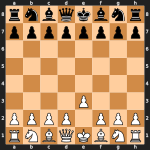

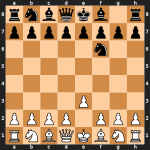

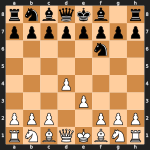

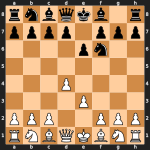

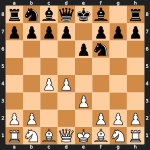

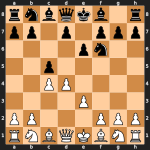

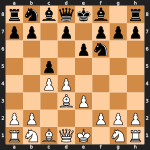

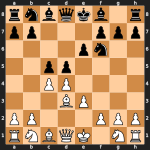

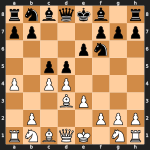

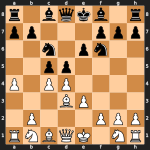

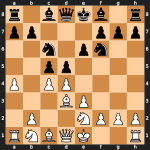

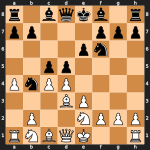

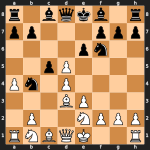

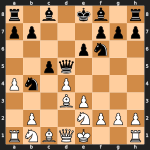

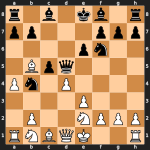

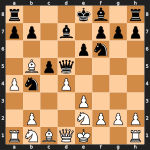

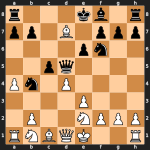

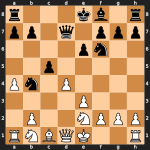

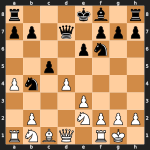

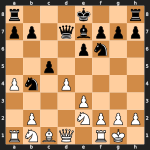

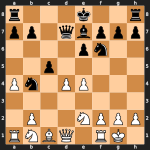

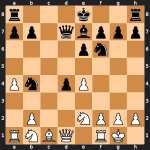

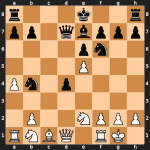

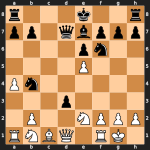

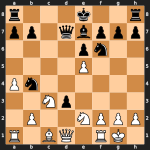

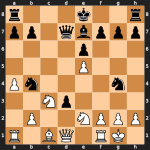

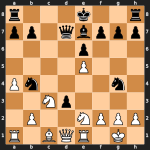

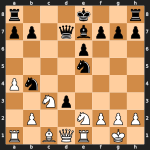

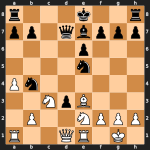

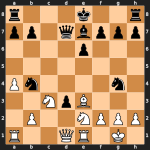

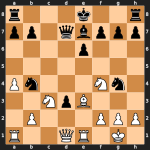

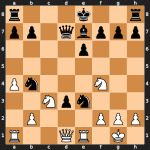

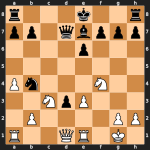

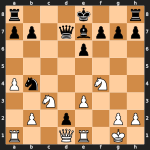

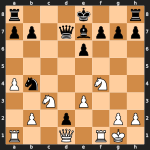

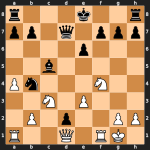

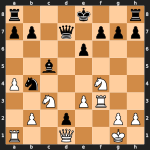

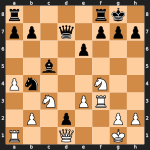

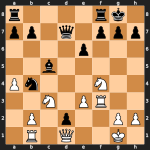

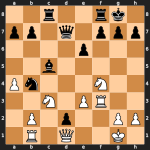

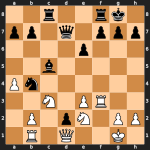

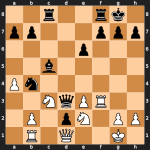

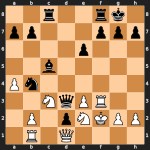

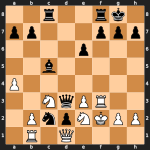

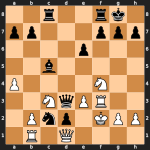

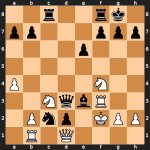

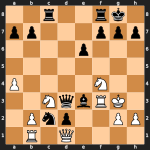

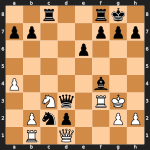

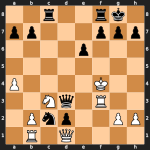

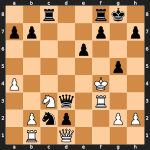

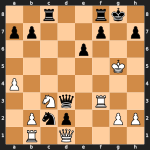

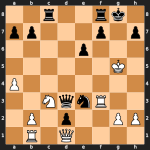

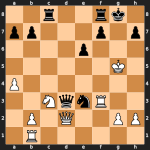

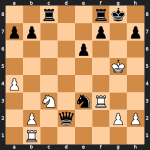

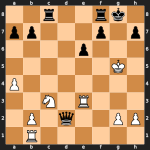

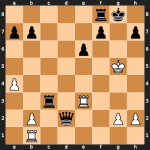

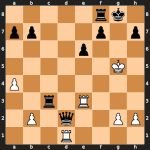

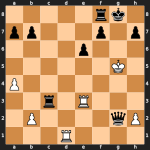

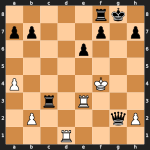

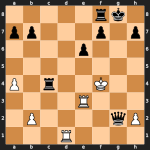

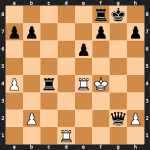

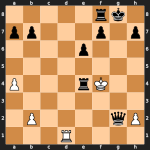

In [30]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish") as sf:
  while True:
    move = get_ai_move(board, 2)
    board.push(move)
    display(SVG(chess.svg.board(board=board, size=150)))  # Display board image
    # print('\nWhite plays...')
    # print(board)
    if board.is_game_over():
      break

    move = sf.analyse(board, chess.engine.Limit(depth=3))['pv'][0]
    # move = sf.analyse(board, chess.engine.Limit(time=1))['pv'][0]
    board.push(move)
    display(SVG(chess.svg.board(board=board, size=150)))  # Display board image
    # print('\nBlack plays...')
    # print(board)
    if board.is_game_over():
      break